In [187]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*1.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['qs', 'ms', 'nus', 'pos', 'n', 'stopcond', 'vprel', 'B0', 'damping', 'w', 'time', 'Nspec', 'Ns', 'vgrel']


/shared/users/asousa/software/python2/lib/python2.7/site-packages/spacepy/time.py:330: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  return Ticktock(self.UTC[idx])
/shared/users/asousa/software/python2/lib/python2.7/site-packages/spacepy/coordinates.py:192: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  return Coords(arr[idx].tolist(), self.dtype, self.carsph, self.units, t_select)


<IPython.core.display.Javascript object>


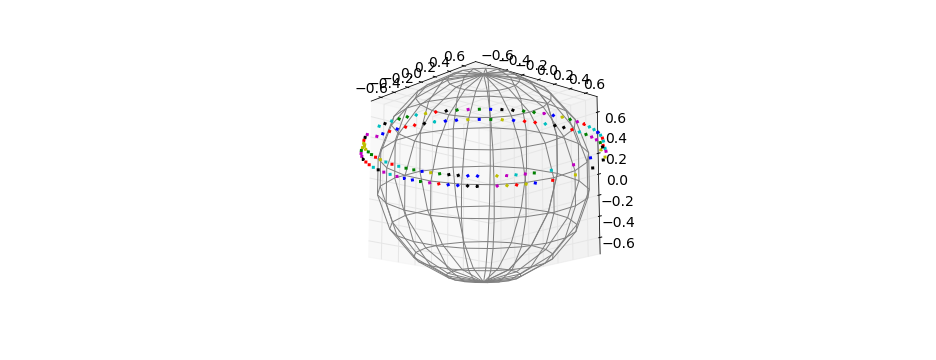

In [312]:
# ----- Plot rays (3d version) -----

# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/lightning_power_study/rays/globe_kp0/'
rayF = 200
lat_min = 0
lat_max = 11
lon_min = 9
lon_max = 360


rf = read_rayfiles(ray_root,rayF, lat_min, lat_max, lon_min, lon_max)

print rf[0].keys()

flashtime = dt.datetime(2001, 1, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

tmax = 5
psize = 4
# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays.append(tmp_coords[r['time'] < tmax])

#     derp = tmp_coords[0]
#     derp = derp.convert('MAG','sph')
#     print derp
    

# -------- 3D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# Plot the earth
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="grey")


# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=3)

ax.set_xlim([-psize, psize])
ax.set_ylim([-psize, psize])
ax.set_zlim([-psize, psize])

ax.view_init(elev=90, azim=0)






<IPython.core.display.Javascript object>


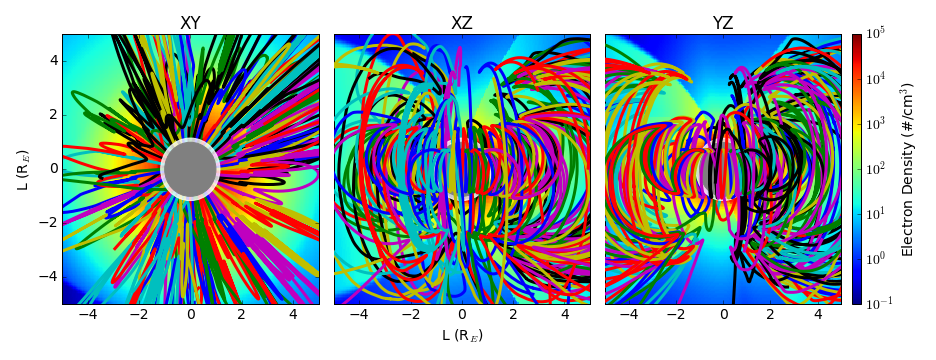

(200, 200)
(200, 200)
(200, 200)


In [317]:
from raytracer_utils import readdump
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 12  # width in inches
fig_height = 4      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------



H_IONO=1000e3

# 2d topdown plots
# ----- Plot rays (3d version) -----

# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/lightning_power_study/rays/globe_kp0/'
rayF = 200
lat_min = 34
lat_max = 36
lon_min = 0
lon_max = 360

figtitle = 'mode1_igrf_1k.png'

rf = read_rayfiles(ray_root,rayF, lat_min, lat_max, lon_min, lon_max)
plasma_model_dump = os.path.join(ray_root, 'model_dump_mode2_1_XY.dat')
d_xy = readdump(plasma_model_dump)
plasma_model_dump = os.path.join(ray_root, 'model_dump_mode2_1_XZ.dat')
d_xz = readdump(plasma_model_dump)
plasma_model_dump = os.path.join(ray_root, 'model_dump_mode2_1_YZ.dat')
d_yz = readdump(plasma_model_dump)

Ne_xy = d_xy['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_xy[np.isnan(Ne_xy)] = 0
Ne_xz = d_xz['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_xz[np.isnan(Ne_xz)] = 0
Ne_yz = d_yz['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_yz[np.isnan(Ne_yz)] = 0

px = np.linspace(-5,5, 200)
py = np.linspace(-5,5, 200)


flashtime = dt.datetime(2010, 8, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

psize = 5
clims = [-1, 5]
# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays.append(tmp_coords)

#     derp = tmp_coords[0]
#     derp = derp.convert('MAG','sph')
#     print derp
    

# -------- 2D Plots -------------------
fig, ax = plt.subplots(1,3)

# ax[0].set_aspect("equal")
# ax[1].set_aspect("equal")
# ax[2].set_aspect("equal")

print np.shape(Ne_xy)
print np.shape(Ne_xz)
print np.shape(Ne_yz)

# Plot background plasma (equatorial slice)
p0 = ax[0].pcolormesh(px,py,np.log10(Ne_xy))
p0.set_clim(clims)
p1 = ax[1].pcolormesh(px,py,np.log10(Ne_xz))
p1.set_clim(clims)
p2 = ax[2].pcolormesh(px,py,np.log10(Ne_yz))
p2.set_clim(clims)



divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right",size="4%",pad=0.15)
cb = plt.colorbar(p2, cax=cax)
cb.set_label('Electron Density (#/cm$^3$)')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)


tmax = 5


# Plot the earth
for i in [0, 1, 2]:
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
    iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
    ax[i].add_patch(earth)   
    ax[i].add_patch(iono)
    
# Plot rays:
for r in rays:
    ax[0].plot(r.x/R_E, r.y/R_E, linewidth=3)
    if r.y[0] < 0:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=3, zorder=101)
    else:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=3, zorder=10)
    if r.x[0] > 0:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=3, zorder=101)
    else:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=3, zorder=10)


ax[0].set_title('XY')
ax[1].set_title('XZ')
ax[2].set_title('YZ')
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].set_xlabel('L (R$_E$)')
ax[0].set_ylabel('L (R$_E$)')

ax[0].set_xlim([-psize, psize])
ax[0].set_ylim([-psize, psize])
ax[1].set_xlim([-psize, psize])
ax[1].set_ylim([-psize, psize])
ax[2].set_xlim([-psize, psize])
ax[2].set_ylim([-psize, psize])

fig.tight_layout()

# fig.savefig(figtitle, ldpi=300)
 


['qs', 'ms', 'nus', 'pos', 'n', 'stopcond', 'vprel', 'B0', 'damping', 'w', 'time', 'Nspec', 'Ns', 'vgrel']


<IPython.core.display.Javascript object>


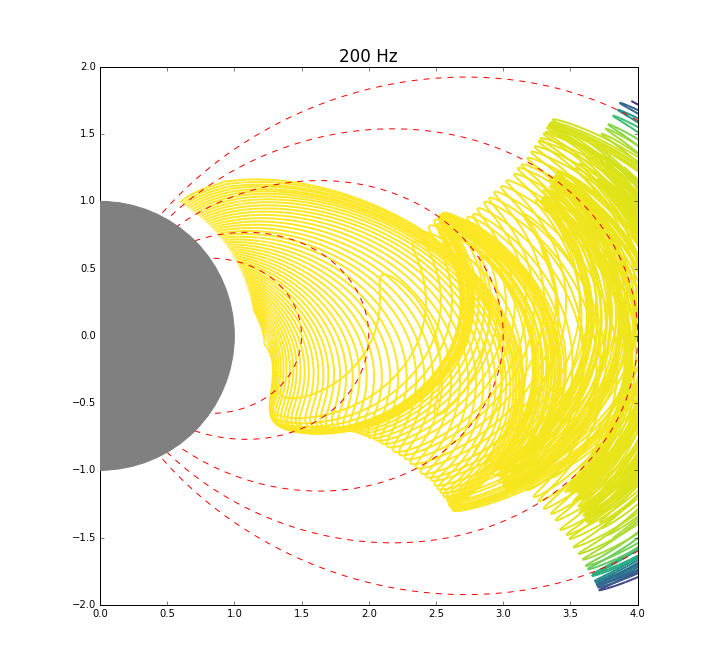

In [51]:
from matplotlib import collections  as mc
# freqs = [200, 300, 400, 500, 600, 1000, 30000]
f1 = 200; f2 = 30000;
num_freqs = 33
flogs = np.linspace(np.log10(f1), np.log10(f2), num_freqs)
freqs = np.round(pow(10, flogs)/10.)*10

flashtime = dt.datetime(2010, 6, 4, 7, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

rootdir = '/shared/users/asousa/WIPP/3dWIPP/outputs/fl_ngo_igrf2/'
for f in freqs[0:1]:
    # rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/rays/ray_200_40_0.ray')
    # rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/freespace/',200, 0, 60, 0,0)
    rf = read_rayfiles(rootdir,f, 0, 90, 0,0)

    # Convert to geographic coordinates for plotting:
    rays = []
    pwr  = []
    print rf[0].keys()

    D2R = np.pi/180.
    L_shells = [1.5, 2, 3, 4, 5]
    # -------- 2D Plot -------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    psize = 4

    # Plot the earth
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
    ax.add_patch(earth)                    # The earth (round)

    # Plot the fieldlines
    for L in L_shells:
        lam = np.linspace(-80,80,181)
        L_r = L*pow(np.cos(lam*D2R),2)
        Lx  = L_r*np.cos(lam*D2R)
        Ly  = L_r*np.sin(lam*D2R)
        ax.plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')  # Field line





    for r in rf:

        tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
        tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
        tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks

        tmp_coords = tmp_coords.convert('MAG','car')
        tmp_coords.sim_time = r['time']

        tmp_coords.pwr = r['damping']

#         print r['stopcond']
        rays.append(tmp_coords)
    #     # calc propagation angle to B0:
    #     dd = r['pos'].iloc[0,:]
    #     bb = r['B0'].iloc[0,:]

    # #     print np.asarray(dd/np.linalg.norm(dd)), np.asarray(bb/np.linalg.norm(bb))

    # #     tb = (180./np.pi)*np.dot(dd, bb)/np.linalg.norm(dd)/np.linalg.norm(bb)
    # # #     print dd, bb
    # #     print tb
    if r['stopcond'] != 0:
        print r['stopcond'] 
    #     print np.linalg.norm(r['vgrel'].iloc[0,:])
    #     print np.linalg.norm(r['n'].iloc[0,:])
    #     print '---'
    # #     print np.linalg.norm(r['pos'].iloc[0])



    # Plot rays:
    for r in rays:
#         ax.plot(np.sqrt(r.x*r.x + r.y*r.y)/R_E, r.z/R_E, linewidth=1, color='b')# marker='.')
    #     # This block to map damping to color:
        C = plt.cm.viridis(r.pwr)
        points = np.array([np.sqrt(r.x*r.x + r.y*r.y)/R_E, r.z/R_E]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = mc.LineCollection(segments, colors=C,alpha=1,linewidth=2)
        ax.add_collection(lc)



        ax.set_xlim([0, psize])
        ax.set_ylim([-psize/2.0, psize/2.0])

    ax.set_title('%d Hz'%f)
    
    plt.savefig(os.path.join(rootdir, 'rays_%dHz.png'%f))

In [258]:
# Get plasma models (XZ plane, y=0)

R_E = 6371e3
maxD = 5*R_E
planes = ['XY', 'XZ','YZ']
use_igrf=1
modelnum=4

for plane in planes:
    if plane=='XZ':
        minx = -maxD
        maxx = maxD
        miny = 0
        maxy = 0
        minz = -maxD
        maxz = maxD
        nx = 200
        ny = 1
        nz = 200
    if plane=='XY':
        minx = -maxD
        maxx = maxD
        miny = -maxD
        maxy = maxD
        minz = 0
        maxz = 0
        nx = 200
        ny = 200
        nz = 1
    if plane=='YZ':    
        minx = 0
        maxx = 0
        miny = -maxD
        maxy = maxD
        minz = -maxD
        maxz = maxD
        nx = 1
        ny = 200
        nz = 200

    outfile='model_dump_mode%d_%d_%s.dat'%(modelnum, use_igrf, plane)
    root_cmd= '/shared/users/asousa/software/raytracer_v1.17/bin/dumpmodel'

    interpfile = '/shared/users/asousa/WIPP/lightning_power_study/gcpm_models/demo_models/gcpm_kp4_2001001_L10_random_5000_20000_0_200000_600000.txt'
    scattered_interp_window_scale = 1.5
    scattered_interp_order = 2
    scattered_interp_exact = 0
    scattered_interp_local_window_scale = 5

    cmd = '%s '%root_cmd +\
        '--minx=%g --maxx=%g '%(minx, maxx) +\
        '--miny=%g --maxy=%g '%(miny, maxy) +\
        '--minz=%g --maxz=%g '%(minz, maxz) +\
        '--nx=%g --ny=%g --nz=%g '%(nx, ny, nz) +\
        '--filename=%s '%(outfile) +\
        '--modelnum=%g '%(modelnum) +\
        '--ngo_configfile=%s '%('newray.in') +\
        '--use_igrf=%g --use_tsyganenko=%g '%(use_igrf,0) +\
        '--interp_interpfile=%s '%(interpfile) +\
        '--tsyganenko_Pdyn=%g '%(0.5) +\
        '--tsyganenko_Dst=%g '%(0) +\
        '--tsyganenko_ByIMF=%g '%(0) +\
        '--tsyganenko_BzIMF=%g '%(0) +\
        '--tsyganenko_W1=%g '%(0) +\
        '--tsyganenko_W2=%g '%(0) +\
        '--tsyganenko_W3=%g '%(0) +\
        '--tsyganenko_W4=%g '%(0) +\
        '--tsyganenko_W5=%g '%(0) +\
        '--tsyganenko_W6=%g '%(0) +\
        '--scattered_interp_window_scale=%d '%(scattered_interp_window_scale) +\
        '--scattered_interp_order=%d '%(scattered_interp_order) +\
        '--scattered_interp_exact=%d '%(scattered_interp_exact) +\
        '--scattered_interp_local_window_scale=%d '%(scattered_interp_local_window_scale)

    print cmd

    os.system(cmd)
    print "done"

/shared/users/asousa/software/raytracer_v1.17/bin/dumpmodel --minx=-3.1855e+07 --maxx=3.1855e+07 --miny=-3.1855e+07 --maxy=3.1855e+07 --minz=0 --maxz=0 --nx=200 --ny=200 --nz=1 --filename=model_dump_mode4_1_XY.dat --modelnum=4 --ngo_configfile=newray.in --use_igrf=1 --use_tsyganenko=0 --interp_interpfile=/shared/users/asousa/WIPP/lightning_power_study/gcpm_models/demo_models/gcpm_kp4_2001001_L10_random_5000_20000_0_200000_600000.txt --tsyganenko_Pdyn=0.5 --tsyganenko_Dst=0 --tsyganenko_ByIMF=0 --tsyganenko_BzIMF=0 --tsyganenko_W1=0 --tsyganenko_W2=0 --tsyganenko_W3=0 --tsyganenko_W4=0 --tsyganenko_W5=0 --tsyganenko_W6=0 --scattered_interp_window_scale=1 --scattered_interp_order=2 --scattered_interp_exact=0 --scattered_interp_local_window_scale=5 
done
/shared/users/asousa/software/raytracer_v1.17/bin/dumpmodel --minx=-3.1855e+07 --maxx=3.1855e+07 --miny=0 --maxy=0 --minz=-3.1855e+07 --maxz=3.1855e+07 --nx=200 --ny=1 --nz=200 --filename=model_dump_mode4_1_XZ.dat --modelnum=4 --ngo_confi

<IPython.core.display.Javascript object>


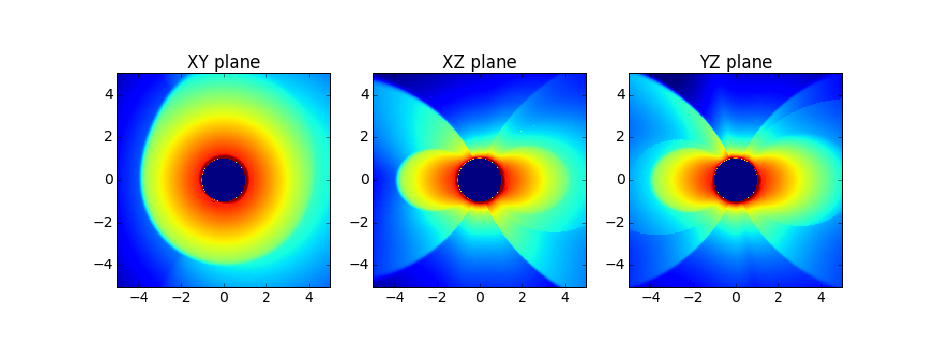

In [301]:
# Plot 3 cross-sections:
from raytracer_utils import readdump

outdir = '/shared/users/asousa/WIPP/lightning_power_study/rays/derg/'
modelnum=2
use_igrf=1
planes = ['XY','XZ','YZ']
clims = [-1, 5]
xlims = [-5, 5]
ylims = [-5, 5]
fig, ax = plt.subplots(1,3)

# Get direction to sun (GSE system - x axis points to sun)
x_in = [1, 0, 0]
time_in = datetime.datetime(2010,3,7,12,0,0)
sun = xf.gse2sm(x_in, time_in)

for ind, plane in enumerate(planes):
    outfile=os.path.join(outdir,'model_dump_mode%d_%d_%s.dat'%(modelnum, use_igrf, plane))
    d = readdump(outfile)

    Ne = d['Ns'][0,:,:,:].squeeze().T*1e-6
    Ne[np.isnan(Ne)] = 0
    
#     # Plot direction to the sun
#     if plane == 'XY':
#         sv = [sun[0], sun[1]]
#     if plane == 'XZ':
#         sv = [sun[0], sun[2]]
#     if plane == 'YZ':
#         sv = [sun[1], sun[2]]
#     ax[ind].plot([0, sv[0]], [0, sv[1]],'w')


    px = np.linspace(-5,5, 200)
    py = np.linspace(-5,5, 200)

    p = ax[ind].pcolormesh(px, py, np.log10(Ne))
    p.set_clim(clims)
    
    
    ax[ind].set_aspect('equal')
    ax[ind].set_xlim(xlims)
    ax[ind].set_ylim(ylims)
    ax[ind].set_title('%s plane'%plane)
    

In [230]:
# Plot XY plane

from raytracer_utils import readdump
outfile='model_dump_mode2_1_XY.dat'


d = readdump(outfile)

print d
Ne = d['Ns'][0,:,:,:].squeeze().T*1e-6
print np.shape(Ne)
Ne[np.isnan(Ne)] = 0
plt.figure()
px = np.linspace(-5,5, nx)
py = np.linspace(-5,5, nz)
# plt.imshow(np.log10(Ne), origin='lower',interpolation='None')
plt.pcolormesh(px,py,np.log10(Ne))
plt.clim([-1,5])
print np.max(Ne)

{'qs': array([[[[ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         ..., 
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19]],

        [[ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         ..., 
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19]],

        [[ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         ..., 
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19]],

        ..., 
        [[ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         ..., 
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19]],

        [[ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         ..., 
         [ -1.60200000e-19],
         [ -1.60200000e-19],
         [ -1.60200000e-19]],

        [[ -1.60200000e-

<IPython.core.display.Javascript object>

TypeError: Dimensions of C (200, 200) are incompatible with X (1) and/or Y (200); see help(pcolormesh)

In [248]:
# Get plasma models (XY plane, z=0)

R_E = 6371e3
minx = -5*R_E
maxx = 5*R_E
miny = -5*R_E
maxy = 5*R_E
minz = 0
maxz = 0
nx = 200
ny = 200
nz = 1
use_igrf=1
modelnum=1
outfile='model_dump_mode%d_igrf_xy.dat'%modelnum
root_cmd= '/shared/users/asousa/software/raytracer_v1.17/bin/dumpmodel'

interpfile = '/shared/users/asousa/WIPP/lightning_power_study/gcpm_models/demo_models/gcpm_kp4_2001001_L10_random_5000_20000_0_200000_600000.txt'
scattered_interp_window_scale = 1.5
scattered_interp_order = 2
scattered_interp_exact = 0
scattered_interp_local_window_scale = 5

cmd = '%s '%root_cmd +\
    '--minx=%g --maxx=%g '%(minx, maxx) +\
    '--miny=%g --maxy=%g '%(miny, maxy) +\
    '--minz=%g --maxz=%g '%(minz, maxz) +\
    '--nx=%g --ny=%g --nz=%g '%(nx, ny, nz) +\
    '--filename=%s '%(outfile) +\
    '--modelnum=%g '%(modelnum) +\
    '--ngo_configfile=%s '%('newray.in') +\
    '--use_igrf=%g --use_tsyganenko=%g '%(use_igrf,0) +\
    '--interp_interpfile=%s '%(interpfile) +\
    '--tsyganenko_Pdyn=%g '%(0.5) +\
    '--tsyganenko_Dst=%g '%(0) +\
    '--tsyganenko_ByIMF=%g '%(0) +\
    '--tsyganenko_BzIMF=%g '%(0) +\
    '--tsyganenko_W1=%g '%(0) +\
    '--tsyganenko_W2=%g '%(0) +\
    '--tsyganenko_W3=%g '%(0) +\
    '--tsyganenko_W4=%g '%(0) +\
    '--tsyganenko_W5=%g '%(0) +\
    '--tsyganenko_W6=%g '%(0) +\
    '--scattered_interp_window_scale=%d '%(scattered_interp_window_scale) +\
    '--scattered_interp_order=%d '%(scattered_interp_order) +\
    '--scattered_interp_exact=%d '%(scattered_interp_exact) +\
    '--scattered_interp_local_window_scale=%d '%(scattered_interp_local_window_scale)
    
print cmd

os.system(cmd)
print "done"

/shared/users/asousa/software/raytracer_v1.17/bin/dumpmodel --minx=-3.1855e+07 --maxx=3.1855e+07 --miny=-3.1855e+07 --maxy=3.1855e+07 --minz=0 --maxz=0 --nx=200 --ny=200 --nz=1 --filename=model_dump_mode1_igrf_xy.dat --modelnum=1 --ngo_configfile=newray.in --use_igrf=1 --use_tsyganenko=0 --interp_interpfile=/shared/users/asousa/WIPP/lightning_power_study/gcpm_models/demo_models/gcpm_kp4_2001001_L10_random_5000_20000_0_200000_600000.txt --tsyganenko_Pdyn=0.5 --tsyganenko_Dst=0 --tsyganenko_ByIMF=0 --tsyganenko_BzIMF=0 --tsyganenko_W1=0 --tsyganenko_W2=0 --tsyganenko_W3=0 --tsyganenko_W4=0 --tsyganenko_W5=0 --tsyganenko_W6=0 --scattered_interp_window_scale=1 --scattered_interp_order=2 --scattered_interp_exact=0 --scattered_interp_local_window_scale=5 
done


<IPython.core.display.Javascript object>


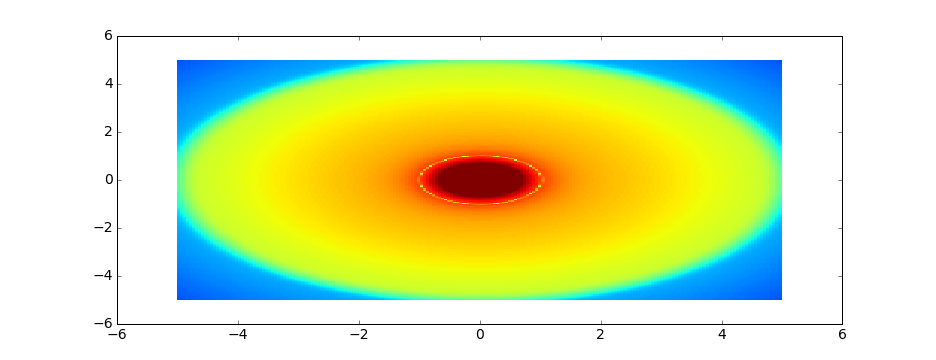

1.3085352069e+64


In [256]:
# Plot XZ plane

from raytracer_utils import readdump
outfile='model_dump_mode1_1_XY.dat'


d = readdump(outfile)


Ne = d['Ns'][0,:,:,:].squeeze().T*1e-6
Ne[np.isnan(Ne)] = 0
plt.figure()
px = np.linspace(-5,5, nx)
py = np.linspace(-5,5, ny)
# plt.imshow(np.log10(Ne), origin='lower',interpolation='None')
plt.pcolormesh(px,py,np.log10(Ne))
plt.clim([-1,5])
print np.max(Ne)

<IPython.core.display.Javascript object>


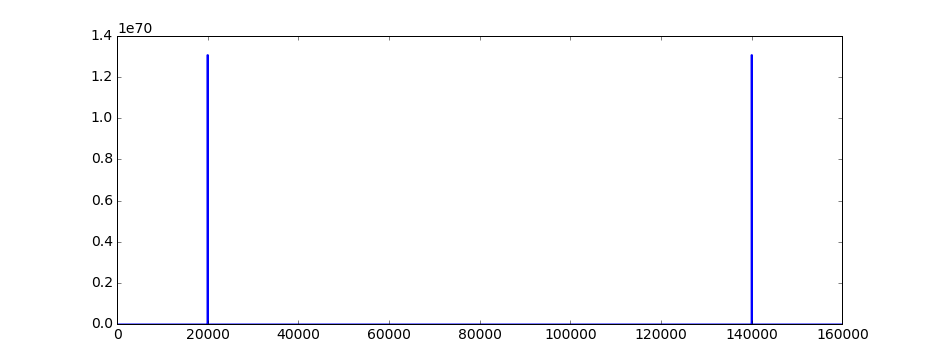

In [249]:
# Plot XY plane

from raytracer_utils import readdump
outfile='model_dump_mode1_1_XY.dat'


d = readdump(outfile)
d.keys()
fig = plt.figure()
plt.plot(d['Ns'].flatten())

In [297]:
import xflib  # Fortran xform-double library (coordinate transforms)
import datetime
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')

x_in = [1, 0, 0]
time_in = datetime.datetime(2010,6,21,15,0,0)
xf.gse2sm(x_in, time_in)

[0.8447458568738301, 0.0, 0.5351676721313597]

In [306]:
import itertools

itertools.product?

In [ ]:
td = datetime.timedelta

In [314]:
r['time']

/shared/users/asousa/software/python2/lib/python2.7/site-packages/spacepy/time.py:330: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return Ticktock(self.UTC[idx])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices